In [1]:
# Instalamos open cv en caso no se cuente con el
!pip install opencv-python

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
# Se importan las librerías que utilizaremos
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import numpy as np

## Datos de transformación

In [3]:
# Se importa la información de los caminantes
df = pd.read_csv('../Data/caminantes.csv',sep=';')
df.head()

,Number,Frame,headValid,bodyValid,headLeft,headTop,headRight,headBottom,bodyLeft,bodyTop,bodyRight,bodyBottom
0,0,2,1,1,"295,626","811,142","334,374","851,827","260,713","811,142","396,615","1121,977"
1,1,2,1,1,"901,68","402,431","927,32","430,35","877,443","402,431","957,062","624,178"
2,2,2,1,1,"1646,674","935,667","1691,326","982,208","1596,772","935,667","1729,112","1293,447"
3,3,2,1,1,"882,242","49,998","896,758","65,783","866,204","49,998","916,275","179,462"
4,4,2,1,1,"740,066","229,356","759,934","250,987","719,841","229,356","786,812","405,142"


In [4]:
T_Matrix = [[ 1.43809441e+00 , 7.58290450e+00  ,7.93117275e+02],
             [-6.80696958e-01 , 8.22103159e+00  ,1.35956100e+03],
             [-7.73887614e-06  ,1.76518761e-03  ,1.00000000e+00]]
#6 lozas de ancho - Aproximamos ancho de 40 cm
#15 Lozas de alto - Aproximamos largo de 40 cm
pix_unit = 1.7 #pixeles por centimetro
width_street = 240*pix_unit
height_street = 600*pix_unit
width_img = 5000
height_img = 3500
#Dimensiones de la imagen final
final_size=(width_img,height_img)

##  Obtención de puntitos

In [5]:
# Funcion para mostrar 3 primeros frames de video junto con las ventanas para la deteccion de personas y caras
def Head_points(path): 
    vidObj = cv2.VideoCapture(path) 
    count = 0
    success = 1
    while success and count<2: 
        success, image = vidObj.read() 
        filter_df = df[df['Frame']==(count+1)]
        head_points = []
        for index,row in filter_df.iterrows():
            start_point = (int(float(row['headLeft'].replace(',','.'))), int(float(row['headTop'].replace(',','.'))) )
            end_point = (int(float(row['headRight'].replace(',','.'))), int(float(row['headBottom'].replace(',','.')))) 
            color = (255, 0, 0) 
            thickness = 2
            image = cv2.rectangle(image, start_point, end_point, color, thickness) 
            start_point2 = (int(float(row['bodyLeft'].replace(',','.'))), int(float(row['bodyTop'].replace(',','.'))) )
            end_point2 = (int(float(row['bodyRight'].replace(',','.'))), int(float(row['bodyBottom'].replace(',','.')))) 
            color2 = (0, 255, 0) 
            image = cv2.rectangle(image, start_point2, end_point2, color2, thickness)
            head_point = (int(start_point[0]/2+end_point[0]/2),int(start_point[1]/2+end_point[1]/2))
            head_points.append(head_point)
            cv2.circle(image,head_point, 30, (0,0,255), -1)
        b,g,r = cv2.split(image)
        frame_rgb = cv2.merge((r,g,b))
        plt.figure(figsize = (20,8))
        plt.subplot(121)
        plt.title('Original') 
        plt.imshow(frame_rgb)
        plt.show()
        clear_output(wait=True)
        count += 1
    return np.array(head_points)

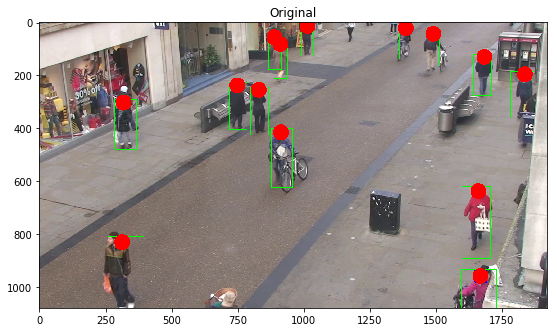

In [6]:
# Se aplica la funcion para visualizar 3 frames del video
head_points_frame = Head_points('../Data/calle.avi')

In [7]:
print(head_points_frame)

[[ 314  831]
 [ 914  416]
 [1668  958]
 [ 889   57]
 [ 749  239]
 [ 319  304]
 [1014   15]
 [1490   44]
 [ 912   83]
 [1836  197]
 [1660  638]
 [1386   22]
 [1683  131]
 [ 830  256]]


## Funcion para aplicar las transformaciones

In [48]:
def TransformPoints(in_points,T_Matrix):
    #Aplicacion de la transformación
    if in_points !=[]:
        puntos_np = np.array([in_points], dtype=np.float32)
        out_points = cv2.perspectiveTransform(puntos_np,np.array(T_Matrix))
    else:
        return []
    return out_points[0]

In [15]:
#transformación de los puntos
head_transform_points=TransformPoints(head_points_frame,T_Matrix)
head_transform_points

array([[3061.9814 , 3237.0422 ],
       [3046.4844 , 2406.9277 ],
       [3904.3054 , 3024.451  ],
       [2289.2263 , 1118.2043 ],
       [2600.5276 , 1987.5563 ],
       [2318.5974 , 2373.703  ],
       [2321.8315 ,  778.15234],
       [3066.7021 ,  663.1865 ],
       [2399.433  , 1247.1874 ],
       [3694.9138 , 1296.8138 ],
       [3794.1055 , 2590.5032 ],
       [2872.4023 ,  580.6566 ],
       [3453.2415 , 1059.6677 ],
       [2717.4368 , 2005.6986 ]], dtype=float32)

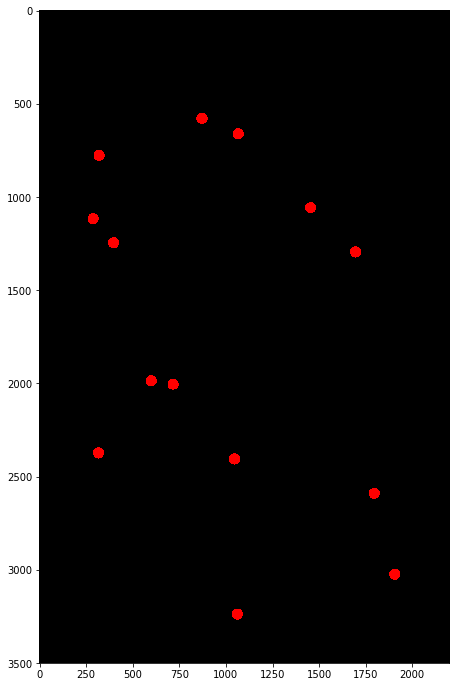

In [21]:
blank_image = np.zeros((height_img,width_img ,3), np.uint8)
# se dibujan los puntos en la imagen de ojo de halcon
for point in head_transform_points:
    cv2.circle(blank_image,tuple(point), 30, (0,0,255), -1)
b,g,r = cv2.split(blank_image)
frame_rgb = cv2.merge((r,g,b))
frame_rgb= frame_rgb[0:3500,2000:4200]
plt.figure(figsize=(12, 12))
plt.imshow(frame_rgb)
plt.show()

## Visualización de video con detección de personas

In [22]:
def ViewTransformPoints(transform_points,height_img,width_img):
    blank_image = np.zeros((height_img,width_img ,3), np.uint8)
    # se dibujan los puntos en la imagen de ojo de halcon
    for point in transform_points:
        cv2.circle(blank_image,tuple(point), 30, (0,0,255), -1)
    b,g,r = cv2.split(blank_image)
    frame_rgb = cv2.merge((r,g,b))
    frame_rgb= frame_rgb[0:3500,2000:4200]
    return frame_rgb

In [52]:
# Funcion para mostrar 20 primeros frames de video junto con las ventanas para la deteccion de personas y caras
def VideoPoints(path): 
    vidObj = cv2.VideoCapture(path) 
    count = 0
    success = 1
    while success and count<20: 
        success, image = vidObj.read() 
        filter_df = df[df['Frame']==(count+1)]
        head_points = []
        for index,row in filter_df.iterrows():
            start_point = (int(float(row['headLeft'].replace(',','.'))), int(float(row['headTop'].replace(',','.'))) )
            end_point = (int(float(row['headRight'].replace(',','.'))), int(float(row['headBottom'].replace(',','.')))) 
            color = (255, 0, 0) 
            thickness = 2
            image = cv2.rectangle(image, start_point, end_point, color, thickness) 
            start_point2 = (int(float(row['bodyLeft'].replace(',','.'))), int(float(row['bodyTop'].replace(',','.'))) )
            end_point2 = (int(float(row['bodyRight'].replace(',','.'))), int(float(row['bodyBottom'].replace(',','.')))) 
            color2 = (0, 255, 0) 
            image = cv2.rectangle(image, start_point2, end_point2, color2, thickness)
            head_point = (int(start_point[0]/2+end_point[0]/2),int(start_point[1]/2+end_point[1]/2))
            head_points.append(head_point)
            cv2.circle(image,head_point, 30, (0,0,255), -1)
        head_transform_points=TransformPoints(np.array(head_points),T_Matrix)
        falcon_image=ViewTransformPoints(head_transform_points,height_img,width_img)
        b,g,r = cv2.split(image)
        frame_rgb = cv2.merge((r,g,b))
        plt.figure(figsize = (20,8))
        plt.subplot(121)
        plt.title('Original') 
        plt.imshow(frame_rgb)
        plt.subplot(122)
        plt.imshow(falcon_image)
        plt.title('Ojo de halcon') 
        plt.show()
        clear_output(wait=True)
        count += 1

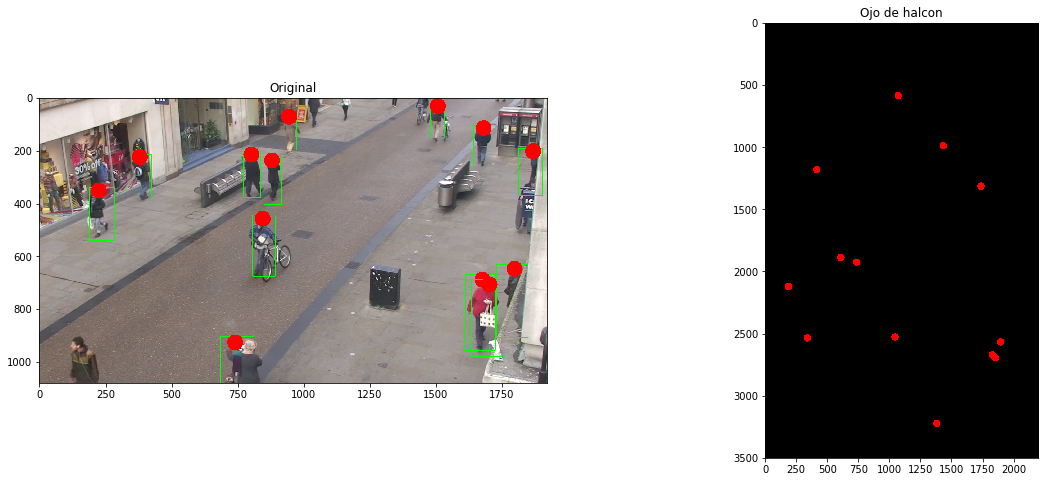

In [53]:
# Se aplica la funcion para visualizar 20 frames del video
VideoPoints('../Data/calle.avi')

### Conclusión:
- Se obtiene una vista de halcon con puntos que hacen referencia a las personas
- Se requiere un filtrado para casos como el de la señora de la izquierda